In [12]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Pre-download NLTK data files
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Enhanced text cleaning function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text.strip()  # Remove extra whitespace

# Load and preprocess dataset
df = pd.read_csv('/content/combined_data.csv', engine='python', skipfooter=1, on_bad_lines='skip')
df['review'] = df['review'].apply(preprocess_text)
df['sentiment'] = df['rating'].apply(lambda x: 'POSITIVE' if x >= 4 else 'NEUTRAL' if x == 3 else 'NEGATIVE')

# Reduce the dataset size for faster processing (optional)
df = df[['review', 'sentiment']].sample(frac=0.1, random_state=42)

# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Tokenize datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to Dataset format and include attention masks
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.map({'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2})
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.map({'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2})
})

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',  # Updated from 'evaluation_strategy' to 'eval_strategy'
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Adjust batch size as needed
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision training for faster processing
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('./fine-tuned-roberta')
tokenizer.save_pretrained('./fine-tuned-roberta')

# Evaluate the model
results = trainer.evaluate()
print("Evaluation results:", results)

# Logistic Regression model on the extracted features
clf = LogisticRegression(max_iter=1000)
train_features = train_encodings['input_ids']
test_features = test_encodings['input_ids']
clf.fit(train_features, train_labels.map({'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2}))

# Predict on the test set
test_predictions = clf.predict(test_features)

# Evaluate the classifier
accuracy = accuracy_score(test_labels.map({'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2}), test_predictions)
print(f"Test Accuracy: {accuracy}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.506100,0.508710
2,0.422500,0.443746
3,0.378200,0.576157


Evaluation results: {'eval_loss': 0.5761569738388062, 'eval_runtime': 11.8729, 'eval_samples_per_second': 362.337, 'eval_steps_per_second': 45.313, 'epoch': 3.0}
Test Accuracy: 0.7805671780567178


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
# Save the fine-tuned model
model.save_pretrained('./fine-tuned-roberta')
tokenizer.save_pretrained('./fine-tuned-roberta')

# Evaluate the model
results = trainer.evaluate()
print("Evaluation results:", results)

# Logistic Regression model on the extracted features
clf = LogisticRegression(max_iter=1000)
train_features = train_encodings['input_ids']
test_features = test_encodings['input_ids']
clf.fit(train_features, train_labels.map({'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2}))

# Predict on the test set
test_predictions = clf.predict(test_features)

# Evaluate the classifier
accuracy = accuracy_score(test_labels.map({'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2}), test_predictions)
print(f"Test Accuracy: {accuracy}")

Evaluation results: {'eval_loss': 0.5761569738388062, 'eval_runtime': 22.8799, 'eval_samples_per_second': 188.025, 'eval_steps_per_second': 23.514, 'epoch': 3.0}
Test Accuracy: 0.7805671780567178


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

# Load the fine-tuned model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('./fine-tuned-roberta')
tokenizer = RobertaTokenizer.from_pretrained('./fine-tuned-roberta')

# Set the model to evaluation mode
model.eval()

# Function to predict sentiment on new text
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to probabilities and get the sentiment with the highest probability
    probabilities = torch.softmax(logits, dim=1).squeeze()
    sentiment = torch.argmax(probabilities).item()

    # Map the sentiment to labels
    sentiment_labels = {0: 'POSITIVE', 1: 'NEUTRAL', 2: 'NEGATIVE'}
    return sentiment_labels[sentiment], probabilities

# Example usage
sample_text = "This drug was very effective and had minimal side effects."
predicted_sentiment, probabilities = predict_sentiment(sample_text)

print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Sentiment Probabilities: {probabilities}")


Predicted Sentiment: POSITIVE
Sentiment Probabilities: tensor([0.9973, 0.0011, 0.0016])


Probabilities:
POSITIVE: 0.9973
NEUTRAL: 0.0011
NEGATIVE: 0.0016
Predicted Sentiment: POSITIVE
Probabilities:
POSITIVE: 0.9973
NEUTRAL: 0.0011
NEGATIVE: 0.0016
Probabilities:
POSITIVE: 0.0186
NEUTRAL: 0.0181
NEGATIVE: 0.9633
Probabilities:
POSITIVE: 0.0210
NEUTRAL: 0.0235
NEGATIVE: 0.9555
Probabilities:
POSITIVE: 0.9975
NEUTRAL: 0.0009
NEGATIVE: 0.0016
Probabilities:
POSITIVE: 0.0261
NEUTRAL: 0.0275
NEGATIVE: 0.9465


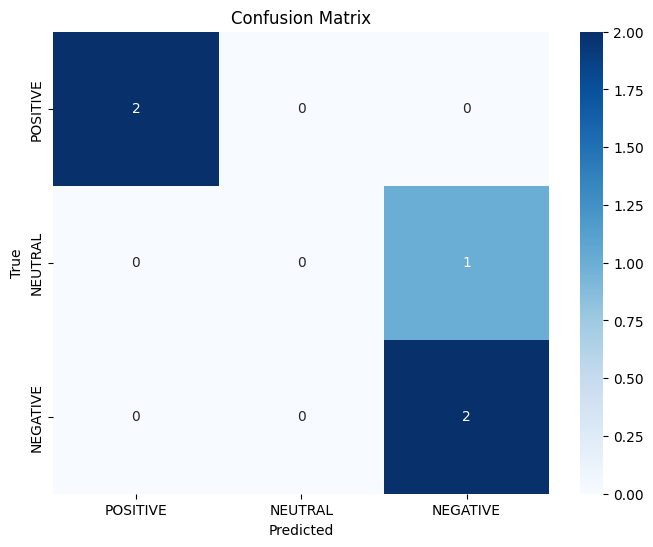


Classification Report:
              precision    recall  f1-score   support

    POSITIVE       1.00      1.00      1.00         2
     NEUTRAL       0.00      0.00      0.00         1
    NEGATIVE       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.56      0.67      0.60         5
weighted avg       0.67      0.80      0.72         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Load the fine-tuned model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('./fine-tuned-roberta')
tokenizer = RobertaTokenizer.from_pretrained('./fine-tuned-roberta')

# Set the model to evaluation mode
model.eval()

# Function to predict sentiment on new text
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to probabilities
    probabilities = torch.softmax(logits, dim=1).squeeze()

    # Get the sentiment with the highest probability
    sentiment = torch.argmax(probabilities).item()

    # Map the sentiment to labels
    sentiment_labels = {0: 'POSITIVE', 1: 'NEUTRAL', 2: 'NEGATIVE'}

    # Print probability of each classification
    print("Probabilities:")
    for i, label in sentiment_labels.items():
        print(f"{label}: {probabilities[i]:.4f}")

    return sentiment_labels[sentiment], probabilities

# Example usage
sample_text = "This drug was very effective and had minimal side effects."
predicted_sentiment, probabilities = predict_sentiment(sample_text)

print(f"Predicted Sentiment: {predicted_sentiment}")

# Test the model on a list of sample texts
test_texts = [
    "This drug was very effective and had minimal side effects.",
    "I felt terrible after taking this medication.",
    "It didn't make much of a difference.",
    "Completely cured my headache.",
    "I experienced severe dizziness and nausea."
]

# True labels for the test texts (these should correspond to the order of your test_texts)
true_labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'POSITIVE', 'NEGATIVE']

# Predict sentiments for the test texts
predicted_labels = [predict_sentiment(text)[0] for text in test_texts]

# Map sentiment labels to numerical values for the confusion matrix
label_mapping = {'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2}
true_labels_num = [label_mapping[label] for label in true_labels]
predicted_labels_num = [label_mapping[label] for label in predicted_labels]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels_num, predicted_labels_num)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], yticklabels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels_num, predicted_labels_num, target_names=['POSITIVE', 'NEUTRAL', 'NEGATIVE']))
